# Stereo Visual Odometry
This notebook apply stereo depth estimation and multiple view geometry to track vehicle position through a sequencee of the images from kitti dataset.

First, let's get the ground truth trajectory

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv

load_dotenv()

poses = pd.read_csv(os.getenv("poses_file"), delimiter=' ', header=None)
poses.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,1.197625e-11,1.704638e-10,5.551115e-17,1.197625e-11,1.000000,3.562503e-10,0.000000,1.704638e-10,3.562503e-10,1.000000,2.220446e-16
1,0.999980,5.025123e-04,-6.380358e-03,-4.596714e-03,-5.005160e-04,1.000000,3.144878e-04,-0.002002,6.380515e-03,-3.112871e-04,0.999980,9.154274e-02
2,0.999910,1.061516e-03,-1.340599e-02,-1.001116e-02,-1.058762e-03,0.999999,2.126022e-04,-0.004360,1.340621e-02,-1.983884e-04,0.999910,1.857373e-01
3,0.999780,1.386756e-03,-2.092925e-02,-1.753371e-02,-1.395506e-03,0.999999,-4.034725e-04,-0.006860,2.092867e-02,4.325913e-04,0.999781,2.834672e-01
4,0.999545,2.025309e-03,-3.008212e-02,-2.863192e-02,-2.080074e-03,0.999996,-1.789331e-03,-0.006727,3.007839e-02,1.851091e-03,0.999546,3.873100e-01


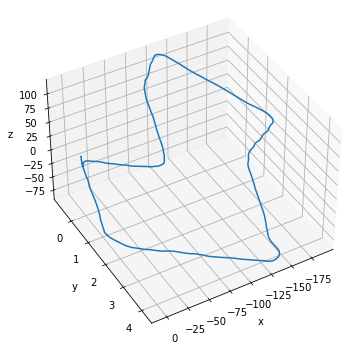

In [26]:
gt: np.ndarray = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))


fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40, azim=60)

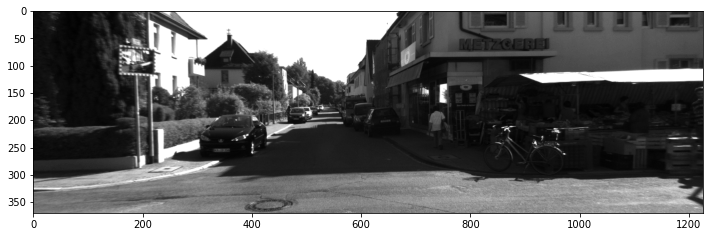

In [40]:
image = plt.imread(os.path.join(os.getenv("l_image_dir"), "0000000000.png"))
plt.figure(figsize=(12,6))
plt.imshow(image, cmap='gray')
plt.show()

## Camera Projection and Calibration


In [29]:
calib = pd.read_csv(os.getenv("calib_file") , delimiter=' ', header=None, index_col=0)
calib.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,707.091200,0.000000,601.88730,0.000000,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,707.091200,0.000000,601.88730,-379.814500,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,707.091200,0.000000,601.88730,46.887830,0.000000,707.091200,183.110400,0.117860,0.000000,0.000000,1.000000,0.006203
P3:,707.091200,0.000000,601.88730,-333.459700,0.000000,707.091200,183.110400,1.930130,0.000000,0.000000,1.000000,0.003318
Tr:,-0.001858,-0.999966,-0.00804,-0.004784,-0.006481,0.008052,-0.999947,-0.073374,0.999977,-0.001806,-0.006496,-0.333997


In calibration file, we can obtain four `3x4` projection matrices for four position camera: `p0`, `p1`, `p2` and `p3`. And we can also obtain the transformation matrix for the LiDAR that denoted as `Tr`.

<div align='center'>
    <img src="../assets/kitti_schematic.png" width='600' alt='stereo' />
</div>

In [5]:

p0: np.ndarray = np.array(calib.loc['P0:']).reshape((3, 4))
p0

array([[707.0912,   0.    , 601.8873,   0.    ],
       [  0.    , 707.0912, 183.1104,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

A projection matrix project three dimensional cooridnates in the global coordinates (world coordinates) onto two dimensional image plane (pixel coordinate)

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{\lambda}P
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix}
$$

where $\lambda$ is known as the scale, which is the depth to the point along z-axis from the camera. The projection matrix `P` is the dot product of intrinsic matrix and extrinsic matrix. The intrinsic matrix `K` that describe the focal length and optical center parameters of camera, and the extrinsic matrix is the augmented matrix of rotation matrix and translation vector that describe the transformation between world coordinates and camera coordinates

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{\lambda}P
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix} = \frac{1}{\lambda}K[R|t]
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix}
$$

In [35]:
p1: np.ndarray = np.array(calib.loc['P1:']).reshape((3, 4))

import cv2
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(p1)
t1 /= t1[3]
print("Intrinsic Matrix:\n", k1)
print("Rotation Matrix:\n", r1)
print("Translation Vector:\n", t1.round(3))


Intrinsic Matrix:
 [[707.0912   0.     601.8873]
 [  0.     707.0912 183.1104]
 [  0.       0.       1.    ]]
Rotation Matrix:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
 [[ 0.537]
 [-0.   ]
 [ 0.   ]
 [ 1.   ]]


In [38]:
Rt: np.ndarray = np.hstack([r1, t1[:3]])
o: np.ndarray = np.array([0, 0, 0, 1])
(Rt @ o).reshape(-1, 1).round(3)

array([[ 0.537],
       [-0.   ],
       [ 0.   ]])

## Dataset Handler
Implement the dataset handler to manipulate the dataset from files, and make it more accessible to complete our mission.

In [ ]:
from dataclasses import dataclass

@dataclass
class ProcessConfig(object):
    pass



class DatasetHandler(object):
    def __init__(self, ) -> None:
        pass

    def _reset(self) -> None:
        pass

## Stereo Depth Estimation



<div align='center'>
    <img src="../assets/stereo.png" width='300' alt='stereo' />
</div>

With similar triangles, we can derive as following:

$$
\frac{Z}{f}=\frac{X}{x_L}, \frac{Z}{f}=\frac{X-b}{x_R}
$$

and we define **disparity `d`** as the difference between $x_L$ amd $x_R$, which means the difference in horizontal pixel location of the point projected onto left and right image plane.

$$
d = (x_L - x_R)
$$

Thus, we can get

$$
fb=Zd \rightarrow Z=\frac{fb}d
$$

In [59]:
import cv2
import datetime
import numpy as np

def compute_disparity_map(
    image_l: np.ndarray,
    image_r: np.ndarray,
    matcher: str = 'bm',
    rgb_map: bool = False,
    verbose: bool = False,
) -> np.ndarray | None:
    if matcher not in ('bm', 'sgbm'):
        raise ValueError('matcher type is not in list.')
    
    if matcher == 'bm':
        _matcher = cv2.StereoBM_create(numDisparities=96, blockSize=11)
    else:
        _matcher = cv2.StereoSGBM_create(
            numDisparities=96,
            minDisparity=0,
            blockSize=11,
            P1 = 8 * 3 * 6 ** 2,
            P2 = 32 * 3 * 6 ** 2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

    if rgb_map:
        image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
        image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)

    ## computing matching
    t0 = datetime.datetime.now()
    disp = _matcher.compute(image_l, image_r).astype(np.float32) / 16
    t1 = datetime.datetime.now()

    if verbose:
        print(f'Time to compute disparity map with stereo{matcher}: {t1 -t0}')
    
    return disp

Time to compute disparity map with stereobm: 0:00:00.016985


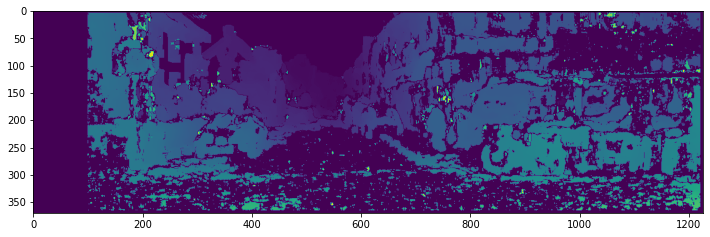

In [72]:
%matplotlib inline
l = cv2.imread(os.path.join(os.getenv("l_image_dir"), "0000000000.png"), 0)
r = cv2.imread(os.path.join(os.getenv("r_image_dir"), "0000000000.png"), 0)

disp = compute_disparity_map(l, r, verbose=True)
plt.figure(figsize=(12,6))
plt.imshow(disp)
plt.show()

Time to compute disparity map with stereosgbm: 0:00:00.038995


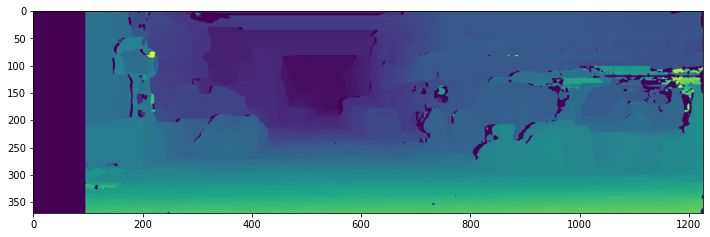

In [71]:
disp = compute_disparity_map(l, r, matcher='sgbm', verbose=True)
plt.figure(figsize=(12,6))
plt.imshow(disp)
plt.show()

## LiDAR Dataset Process
Process the LiDAR data from the dataset, which could be used for depth estimation and odometry correction later.

## Feature Extraction and Matching
Extract the feature from image and matching between each frame to find the transformation relationship in camera poses between a sequences of frames.

In [77]:
from typing import Optional


def extract(image: np.ndarray, detector: str = "sift") -> tuple:
    detectors = { 'sift': cv2.SIFT_create, 'orb': cv2.ORB_create }
    if detector not in detectors:
        raise ValueError("Detector must be 'sift' or 'orb'.")
    
    return detectors[detector]().detectAndCompute(image, None)


def matching(
    des1, des2,
    detector: str = 'sift',
    matcher: str = 'bf',
    sort: bool = True,
    filter_thres: Optional[float] = None,
) -> list[cv2.DMatch]:
    if detector not in ('sift', 'orb'):
        raise ValueError("Detector must be 'sift' or 'orb'.")
    
    if matcher not in ('bf', 'flann'):
        raise ValueError("Matcher must be 'bf' or 'flann'.")
    
    if matcher == 'bf':
        _matcher = cv2.BFMatcher_create(
            cv2.NORM_L2 if detector == 'sift' else cv2.NORM_HAMMING2,
            crossCheck=False
        )
    else:
        _matcher = cv2.FlannBasedMatcher(
            dict(algorithm=1, trees=5),
            dict(checks=50)
        )

    matches = _matcher.knnMatch(des1, des2, 2)
    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance) 

    return [m for m, n in matches if filter_thres is None \
            or m.distance <= filter_thres * n.distance]
    

def visualize(
    image1: np.ndarray, 
    kp1: list,
    image2: np.ndarray,
    kp2: list, 
    matches: list,
) -> None:
    _image = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(_image)
    plt.show()

Number of matches with filtering: 697.


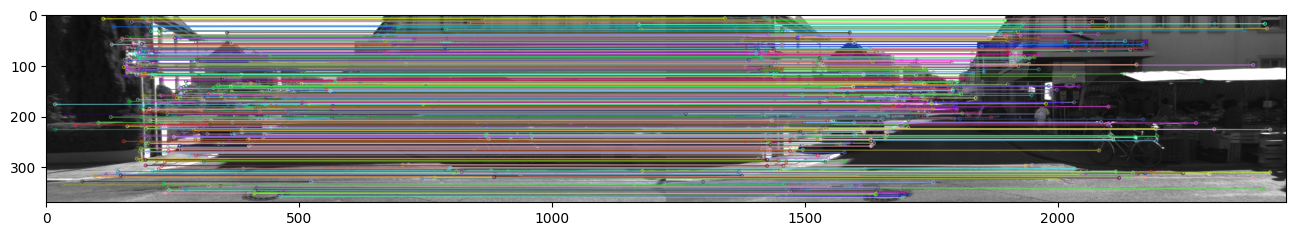

In [78]:
image1 = cv2.imread(os.path.join(os.getenv("l_image_dir"), "0000000000.png"), 0)
image2 = cv2.imread(os.path.join(os.getenv("l_image_dir"), "0000000001.png"), 0)

kp1, des1 = extract(image1)
kp2, des2 = extract(image2)
m = matching(des1, des2, matcher='bf', filter_thres=0.3)
print(f"Number of matches with filtering: {len(m)}.")
visualize(image1, kp1, image2, kp2, m)

Number of matches with filtering: 132.


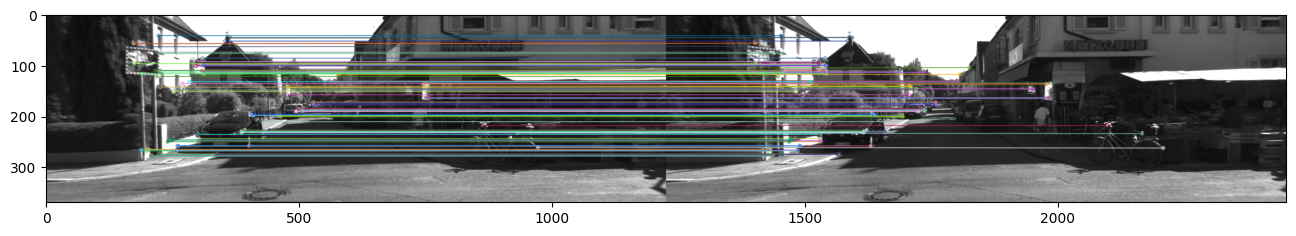

In [79]:
kp1, des1 = extract(image1, 'orb')
kp2, des2 = extract(image2, 'orb')
m = matching(des1, des2, detector='orb', matcher='bf', filter_thres=0.3)
print(f"Number of matches with filtering: {len(m)}.")
visualize(image1, kp1, image2, kp2, m)

## Visual Odometry


In [ ]:
class VO(object):
    def __init__(self) -> None:
        pass

In [ ]:
class CalcError(object):
    def __init__(self, gt: np.ndarray, est: np.ndarray) -> None:
        pass

    @staticmethod
    def _mse(gt: np.ndarray, est: np.ndarray) -> np.float64:
        n: int = est.shape[0]
        se = np.power(np.sqrt(
            np.power(gt[n, 0, 3] - est[:, 0, 3], 2) +  
            np.power(gt[n, 1, 3] - est[:, 1, 3], 2) +
            np.power(gt[n, 2, 3] - est[:, 2, 3], 2) 
        ), 2)
        mse = np.mean(se)
        return mse